In [13]:
from dataclasses import dataclass

import numpy as np

from archive.LBM_MS_Python_CuPy.functions import *

from tqdm import tqdm

from scipy.optimize import curve_fit
from joblib import Parallel, delayed
from itertools import product

In [40]:
@dataclass
class Config:
    nx: int = 200
    ny: int = 50
    steps: int = 1000
    output_stride: int = 200
    molecular_weights: tuple[float, float, float] = (3, 3)

    stripe_width: int = 5

    base_pressure_A: float = 0.05
    base_pressure_B: float = 0.95
    stripe_pressure_A: float = 0.95
    stripe_pressure_B: float = 0.05

    base_pressure_A: float = 0.4
    base_pressure_B: float = 0.6
    stripe_pressure_A: float = 0.6
    stripe_pressure_B: float = 0.4

    initial_ux: float = 0.0
    initial_uy: float = 0.0

    total_pressure: float = 1.0
    theta: float = 0.5
    nB: int = 9

In [41]:
def initialise_stripe(config: Config):
    """Build initial distributions for a vertical A stripe and B elsewhere.

    Returns
    -------
    f : np.ndarray
        Populations, shape (2, 9, nx, ny)
    phi : xp.ndarray
        Equation-of-state factors, shape (2,)
    """
    nx, ny = config.nx, config.ny
    N = 2
    phi = 1.0 / xp.array(config.molecular_weights, dtype=xp.float64)  # EOS factors

    # Partial pressures per species
    pA = xp.full((nx, ny), config.base_pressure_A, dtype=xp.float64)
    pB = xp.full((nx, ny), config.base_pressure_B, dtype=xp.float64)
    s0 = nx // 2 - config.stripe_width // 2
    s1 = s0 + config.stripe_width
    pA[s0:s1, :] = config.stripe_pressure_A
    pB[s0:s1, :] = config.stripe_pressure_B

    # Convert partial pressures to densities: p_sigma = phi_sigma * rho_sigma / 3
    rhoA = 3.0 * pA / phi[0]
    rhoB = 3.0 * pB / phi[1]
    rho_s = xp.stack([rhoA, rhoB], axis=0)  # (2, nx, ny)

    # Build initial equilibrium with a small rightward velocity
    f = xp.zeros((N, 9, nx, ny), dtype=xp.float64)
    ux_s = xp.full((N, nx, ny), config.initial_ux, dtype=xp.float64)
    uy_s = xp.full((N, nx, ny), config.initial_uy, dtype=xp.float64)
    feq = equilibrium(f, rho_s, phi, ux_s, uy_s)
    f[...] = feq
    return f, phi

In [42]:
def diffusion_profile(f):
    phi = 1.0 / xp.array(Config.molecular_weights, dtype=xp.float64)
    rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
    profile = rho_s[0, :, Config.ny/2]
    return profile

def profile_std(profile, background):
    #background = xp.min(profile)
    profile = profile - background
    x = xp.arange(len(profile))
    total_mass = xp.sum(profile)
    x_mean = xp.sum(x * profile) / total_mass
    variance = xp.sum(profile * (x - x_mean) ** 2) / total_mass
    std = xp.sqrt(variance)
    return std

In [43]:
def main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, ini_slope, Config):
    cfg = Config()

    f, phi = initialise_stripe(cfg)
    molecular_weights = xp.array(cfg.molecular_weights, dtype=xp.float64)

    profiles = []
    stds = []

    for step in tqdm(range(cfg.steps + 1)):
        if step % cfg.output_stride == 0:
            save_concentration_frames(f, phi, step, molecular_weights)
        if step == cfg.steps:
            break

        f = bgk_step(f, molecular_weights, phi, cfg.nB, lattice_stream, step,
                     non_absorb_mask, bc_top, bc_bottom)

        profile = diffusion_profile(f)
        #profiles.append(to_numpy(profile))
        profiles.append(profile)
        '''
        if step == 0:
            background = profile[0]
            print(background)
        std = profile_std(profile, background)
        stds.append(std)
        '''

    return f, xp.array(profiles)#, stds

In [44]:
absorption_coefficient = 100
bc_top = None
bc_bottom = None
non_absorb_mask = None

In [45]:
f, profiles= main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, True, Config)

100%|█████████▉| 1000/1001 [00:14<00:00, 70.03it/s]


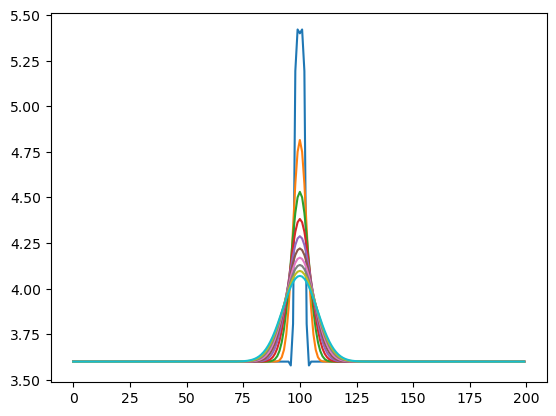

In [46]:
for i in range(Config.steps):
    if i % 100 ==1:
        plt.plot(to_numpy(profiles[i]))

Fit the diffusion rate from std = D * sqrt(t)

In [47]:
def function_diffusion(t, D):
    return np.sqrt(2*D*t)

def calc_diff_coef(profiles):
    background = profiles[0][0]
    stds = []
    for i in range(profiles.shape[0]):
        stds.append(profile_std(profiles[i], background))

    stds = to_numpy(xp.array(stds))
    t_axis = np.arange(profiles.shape[0])
    try:
        popt, pcov = curve_fit(function_diffusion, t_axis[1:], stds[1:])
    except Exception:
        return 0

    return popt[0]

In [48]:
calc_diff_coef(profiles)

C:\Users\19162\AppData\Local\Temp\ipykernel_54468\1568599206.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*D*t)


0.035045550869087276

Plot the measured diffusion and fitting

Diffusion_constant =  [0.03504555]


C:\Users\19162\AppData\Local\Temp\ipykernel_54468\1568599206.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*D*t)


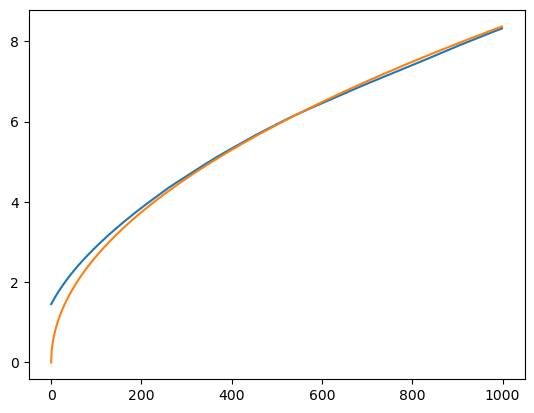

In [49]:
background = profiles[0][0]

stds = []

for i in range(Config.steps):
    stds.append(profile_std(xp.array(profiles[i]), background))

stds = to_numpy(xp.array(stds))

plt.plot(stds)

t_axis = np.arange(Config.steps)
popt, pcov = curve_fit(function_diffusion, t_axis[1:], stds[1:])

print("Diffusion_constant = ", popt)
plt.plot(t_axis, function_diffusion(t_axis, popt))

nb = 9:

same mass:

m = 1, D = 0.057

m = 2, D = 0.041, 72%

m = 3, D = 0.033, 0.035 after changing percentage, 58%

follows the theoretical prediction

In [54]:
nb_table = np.array([0.50,0.60,0.72,0.87,1.05,1.26,1.51,1.82,2.19,2.63,3.16,3.80,4.57,5.49,6.61,7.95,9.56,11.5,13.8,16.6,], dtype = np.float32)
Bss = 10 * nb_table[Config.nB] * 1/np.sqrt(1/Config.molecular_weights[0] + 1/Config.molecular_weights[0])
print('Predict diffusion constant = ', (1/Bss))

Predict diffusion constant =  0.03104549602277473


Parameter sweep

In [82]:
def _single_run(mass_A, nb):

    @dataclass
    class Config:
        nx: int = 200
        ny: int = 50
        steps: int = 1000
        output_stride: int = 200
        molecular_weights: tuple[float, float, float] = (mass_A, 15)

        stripe_width: int = 5

        base_pressure_A: float = 0.05
        base_pressure_B: float = 0.95
        stripe_pressure_A: float = 0.95
        stripe_pressure_B: float = 0.05

        initial_ux: float = 0.0
        initial_uy: float = 0.0

        total_pressure: float = 1.0
        theta: float = 0.5
        nB: int = nb

    f, profiles= main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, True, Config)

    diff_coef = calc_diff_coef(profiles)

    return diff_coef

def parameter_sweep_parallel(n_jobs=2, backend="loky"):

    mass_As = np.arange(1,30,3)
    nbs = np.arange(0, 21, 2)

    mass_As = np.array([1,2])
    nbs = np.array([5,20])

    combos = list(product(mass_As, nbs))

    results = Parallel(n_jobs=n_jobs, backend=backend)(
        delayed(_single_run)(mass_A, nbs)
        for (mass_A, nbs) in combos
    )

    diffusion_coefficients = results

    M,K = len(mass_As), len(nbs)
    diffusion_coefficients_grid = np.empty((M,K))

    idx = 0
    for i in range(M):
        for j in range(K):
            diffusion_coefficients_grid[i,j] = diffusion_coefficients[idx]
            idx += 1

    return mass_As, nbs, diffusion_coefficients_grid

In [83]:
mass_As, nbs, diffusion_coefficients_grid = parameter_sweep_parallel()

In [84]:
print(diffusion_coefficients_grid)

[[2.86614576 0.        ]
 [2.75784348 0.        ]]


In [111]:
#mass_As = np.arange(1,30,3)
#nbs = np.arange(0, 21, 2)
mass_As = np.arange(0,40)
nbs = np.arange(0,20)
print(mass_As)
diff_coef = np.load('diffusion_coefficients.npy')
print(mass_As.shape)
print(diff_coef.shape)

diff_coef[diff_coef>0.2] =0

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(40,)
(40, 20)


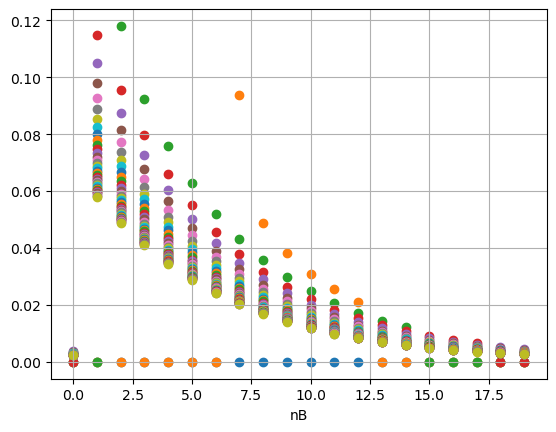

In [113]:
for i in range(1,mass_As.shape[0]):
    plt.scatter(nbs, diff_coef[i,:])

plt.xlabel('nB')
plt.grid()

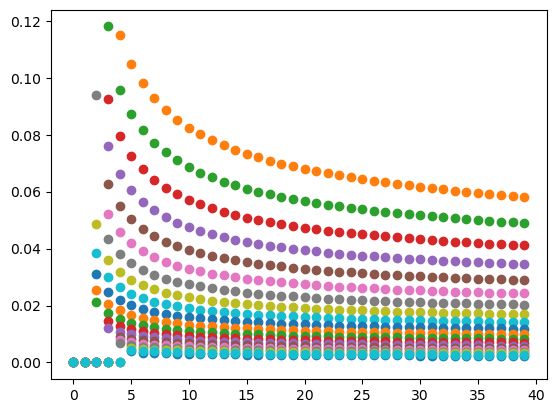

In [116]:
for i in range(nbs.shape[0]):
    plt.scatter(mass_As, diff_coef[:,i])